In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44367")
client

<Client: 'tcp://127.0.0.1:44367' processes=8 threads=40, memory=157.39 GiB>

In [20]:
client.restart()

Connection method: Direct,
Dashboard: http://127.0.0.1:8787/status,
Comm: tcp://127.0.0.1:44367,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: 1 hour ago,Total memory: 0 B


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# from dask.diagnostics import ProgressBar
import os.path as op
import os
import gsw
import time
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib
matplotlib.rcParams['pcolor.shading'] = 'auto'
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 25
yend = 50

Nyears = 50

xchunk = 100
ychunk = 101
schunk = 5
membchunk = 1
dnf = 2160
nfile = 73

In [5]:
ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,1967)), 
                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                     iters=1421280,
                     prefix=['diag_ocnTave'], delta_t=2e2,
                    ).sel(YC=slice(yNstart-12**-1,yend+2*12**-1),
                          YG=slice(yNstart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
ds

<xarray.Dataset>
Dimensions:  (time: 1, XC: 1000, YC: 303, XG: 1000, YG: 303, Z: 46, Zp1: 47, Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3290 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 24.92 25.0 25.08 25.17 25.25 ... 49.83 49.92 50.0 50.08
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 24.96 25.04 25.13 25.21 25.29 ... 49.88 49.96 50.04 50.13
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 101, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 101, 100), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(101, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(101, 100), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(101, 100), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 101, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [6]:
ystart = yNstart
year = 1967
ntimes = np.arange(1421280,1576800+dnf,dnf)

for itime in ntimes:
    if itime == ntimes[0]:
        dsensZ = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Zetab/%010d/' 
                                      % (year,itime))
                             ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                   YG=slice(ystart-12**-1,yend+2*12**-1)
                                  ).reset_coords(drop=True)
        
        dsensD = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynb/%010d/' 
                                      % (year,itime))
                             ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                   YG=slice(ystart-12**-1,yend+2*12**-1)
                                  ).reset_coords(drop=True)
    else:
        dsensZ = xr.concat([dsensZ,xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Zetab/%010d/' 
                                                        % (year,itime))
                                               ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                                     YG=slice(ystart-12**-1,yend+2*12**-1)
                                                    ).reset_coords(drop=True)],
                           'time')
        dsensD = xr.concat([dsensD,xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynb/%010d/' 
                                                        % (year,itime))
                                               ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                                     YG=slice(ystart-12**-1,yend+2*12**-1)
                                                    ).reset_coords(drop=True)],
                           'time')
delta = .5*(dsensZ.delta_outer[1:].data 
            + dsensZ.delta_outer[:-1].data)
dsensZ.coords['delta'] = ('delta',delta)
dsensD.coords['delta'] = ('delta',delta)

imemb = 0
dsannZ = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Zb/ann' 
                              % (imemb))
                     )
dsannD = xr.open_zarr(op.join(tdgs,'5Dave/memb%02d/Dynb/ann' 
                              % (imemb))
                     )

dsensZ

/tmp/ipykernel_13550/1377289445.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  dsensZ = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Zetab/%010d/'
/tmp/ipykernel_13550/1377289445.py:13: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=Fa

,Array,Chunk
Bytes,4.53 GiB,7.68 MiB
Shape,"(73, 303, 1000, 55)","(1, 183, 200, 55)"
Count,29993 Tasks,730 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.53 GiB,7.68 MiB
Shape,"(73, 303, 1000, 55)","(1, 183, 200, 55)"
Count,29993 Tasks,730 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [36]:
buoybp1 = -grav * dsannZ.delta_outer * rhoConst**-1
print(buoybp1[18])
sigmab = -dsensZ.dzetab/buoybp1
sigmab

<xarray.DataArray 'delta_outer' ()>
array(-0.25019235)
Coordinates:
    delta_outer  float64 25.5


,Array,Chunk
Bytes,9.06 GiB,15.36 MiB
Shape,"(73, 303, 1000, 55)","(1, 183, 200, 55)"
Count,31454 Tasks,730 Chunks
Type,float64,numpy.ndarray


In [19]:
ntimes = np.arange(1421280,1576800+dnf,dnf)
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
nstart = 54
print(ntimes[nstart])

1537920


In [21]:
for itime in ntimes[nstart+1:]:
#         if itime == ntimes[0,0]:
    ystart = yNstart
#         else:
#             ystart = yNstart
        
    ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    ds6.coords['delta'] = ('delta',delta)
    upp = ds6.upp
    vpp = ds6.vpp
            
    for imemb in nmembs:
            
        if imemb == 0:
            ds1 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                       % (year,imemb,itime))
                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                    YG=slice(ystart-12**-1,yend+2*12**-1)
                                   ).isel(time=0).reset_coords(drop=True)
                
        else:
            tmp1 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                        % (year,imemb,itime))
                               ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                     YG=slice(ystart-12**-1,yend+2*12**-1)
                                    ).isel(time=0).reset_coords(drop=True)
            ds1 = xr.concat([ds1,tmp1], 'nmemb')
        
    ds1.coords['nmemb'] = ('nmemb',nmembs)
        
    buoyb = -grav * ds6.delta * rhoConst**-1
    buoybp1 = -grav * ds6.delta_outer * rhoConst**-1
        
    grid = Grid(ds6, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
               )

###############################
    dzetaF = ds1.dzetaF.where(ds1.dzetaF!=0.)
    sigma = dzetaF * -grid.diff(buoyb,'Z',boundary='extend')**-1


    EKE = .5*(grid.interp(xr.DataArray(upp.data, dims=['nmemb','YC','XG','delta_outer'],
                                       coords={'YC':ds6.YC.data,'XG':ds6.XG.data,
                                               'delta_outer':ds6.delta_outer.data}
                                      )**2,
                          'X') 
              + grid.interp(xr.DataArray(vpp.data, dims=['nmemb','YG','XC','delta_outer'],
                                         coords={'YG':ds6.YG.data,'XC':ds6.XC.data,
                                                 'delta_outer':ds6.delta_outer.data}
                                        )**2,
                            'Y',boundary='fill')
             )
    EKE = (EKE * sigma).mean('nmemb',skipna=True)

###############################    
    dsave = EKE.to_dataset(name='EKE')
    if itime == ntimes[nstart+1]:
        print(dsave)
    chunks = {'XC':xchunk,'YC':ychunk}
    dsave.chunk(chunks).to_zarr(op.join(tdgs,'5Dave/run%4d/EKE/%010d/' 
                                        % (year,itime)), mode='w')
    dsave.close()
        
###############################  
    ds1.close()
    ds6.close()
    print(itime)
        
    # client.restart()

/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

<xarray.Dataset>
Dimensions:      (YC: 303, XC: 1000, delta_outer: 55)
Coordinates:
  * YC           (YC) float32 24.92 25.0 25.08 25.17 ... 49.83 49.92 50.0 50.08
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Data variables:
    EKE          (YC, XC, delta_outer) float64 dask.array<chunksize=(119, 199, 55), meta=np.ndarray>
1540080


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1542240


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1544400


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1546560


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1548720


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1550880


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1553040


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1555200


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1557360


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1559520


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1561680


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1563840


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1566000


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1568160


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1570320


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1572480


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1574640


/tmp/ipykernel_13550/3355260205.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/'
/tmp/ipykernel_13550/3355260205.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False,

1576800


In [28]:
ystart = yNstart
year = 1967
ntimes = np.arange(1421280,1576800+dnf,dnf)

for itime in ntimes:
    if itime == ntimes[0]:
        dsEKE = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/EKE/%010d/' 
                                     % (year,itime))
                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                 ).reset_coords(drop=True)
    else:
        dsEKE = xr.concat([dsEKE,xr.open_zarr(op.join(tdgs,'5Dave/run%4d/EKE/%010d/' 
                                                       % (year,itime))
                                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).reset_coords(drop=True)],
                          'time')

dsEKE.coords['delta'] = ('delta',delta)
dsEKE

,Array,Chunk
Bytes,9.06 GiB,4.24 MiB
Shape,"(73, 303, 1000, 55)","(1, 101, 100, 55)"
Count,85453 Tasks,2190 Chunks
Type,float64,numpy.ndarray


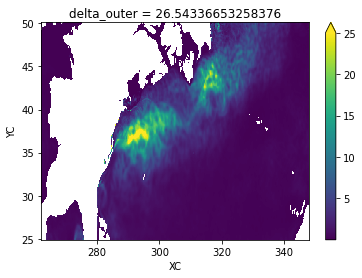

In [40]:
(dsEKE.EKE/sigmab).isel(time=0,delta_outer=23).plot(vmax=2.5e1)

In [25]:
grid = Grid(dsannZ, periodic=['X'], 
            coords={'Z':{'center':'delta','outer':'delta_outer'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   delta --> outer
  * outer    delta_outer --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center

In [41]:
annMKE = .5*(grid.interp(xr.DataArray(dsannD.uhat.data, dims=['time','YC','XG','delta_outer'],
                                      coords={'YC':dsannD.YC.data,'XG':dsannD.XG.data,
                                              'delta_outer':dsannD.delta_outer.data})**2,'X') 
             + grid.interp(xr.DataArray(dsannD.vhat.data, dims=['time','YG','XC','delta_outer'],
                                        coords={'YG':dsannD.YG.data,'XC':dsannD.XC.data,
                                                'delta_outer':dsannD.delta_outer.data})**2,'Y',boundary='fill')
            )
ensMKE = .5*(grid.interp(dsensD.uhat**2,'X') 
             + grid.interp(dsensD.vhat**2,'Y',boundary='fill')
            )
ensEKE = dsEKE.EKE/sigmab
annMKE

,Array,Chunk
Bytes,4.53 GiB,13.78 MiB
Shape,"(73, 303, 1000, 55)","(73, 100, 99, 5)"
Count,18625 Tasks,1320 Chunks
Type,float32,numpy.ndarray


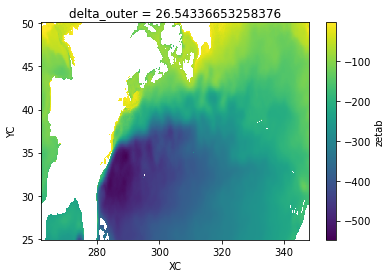

In [95]:
dsensZ.zetab.isel(time=0,delta_outer=23).plot()

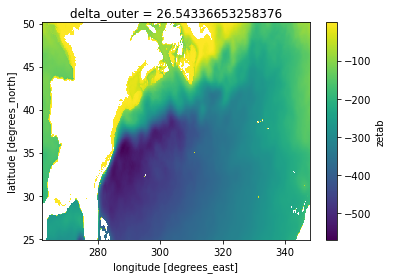

In [96]:
dsannZ.zetab.where(dsannZ.dzetab!=0.).isel(time=0,delta_outer=23).plot()

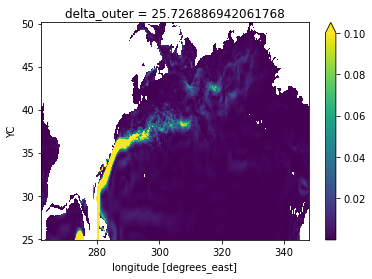

In [47]:
ensKE.isel(time=0,delta_outer=19).plot(vmax=.1)

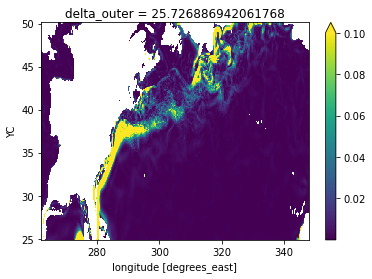

In [48]:
annKE.isel(time=0,delta_outer=19).plot(vmax=.1)

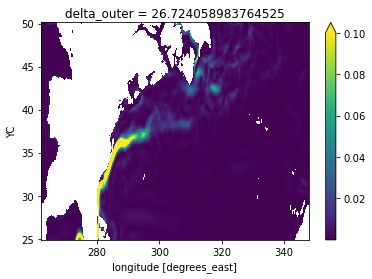

In [97]:
ensKE.isel(time=0,delta_outer=nsig+1).plot(vmax=.1)

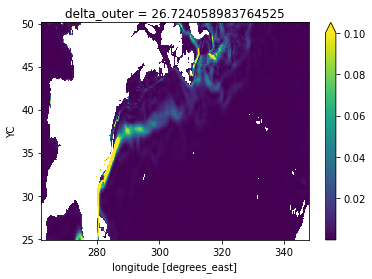

In [98]:
annKE.isel(time=0,delta_outer=nsig+1).plot(vmax=.1)

In [42]:
ensmask = np.ma.masked_invalid(dsensZ.dzetab.where(dsensZ.dzetab!=0.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1)
                                                                         ).isel(time=0)
                              ).mask
annmask = np.ma.masked_invalid(dsannZ.dzetab.where(dsannZ.dzetab!=0.).sel(YC=slice(ySstart+5-12**-1,yend+12**-1)
                                                                         ).isel(time=0)
                              ).mask

/tmp/ipykernel_1264/3922855782.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,0].pcolormesh(ds.XC, ds.YC,
/tmp/ipykernel_1264/3922855782.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(ds.XC, ds.YC,
/tmp/ipykernel_1264/3922855782.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass s

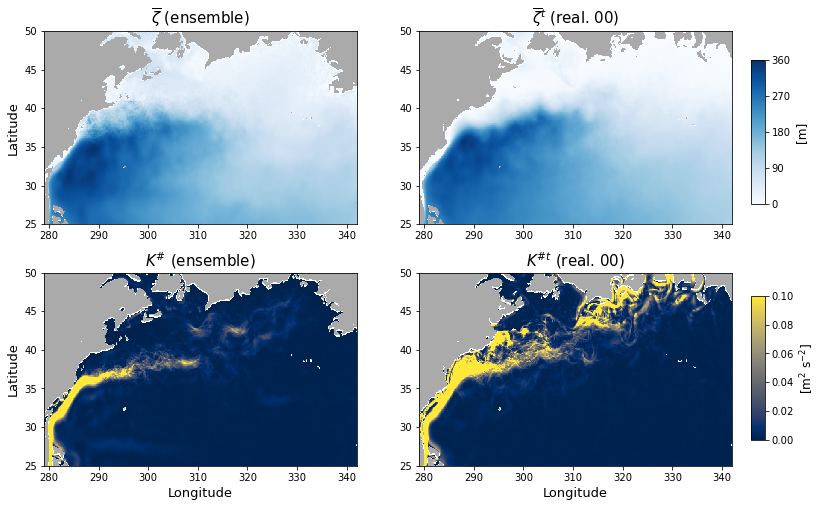

In [71]:
fig, axes = plt.subplots(figsize=(13,8), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(ds.XC, ds.YC, 
                           -dsensZ.zetab.isel(time=0,delta_outer=19), 
                           vmin=0, vmax=3.6e2, shading='auto', cmap='Blues', rasterized=True)
im1 = axes[0,1].pcolormesh(ds.XC, ds.YC, 
                           -dsannZ.zetab.where(dsannZ.dzetab!=0.).isel(time=0,delta_outer=18),
                           vmin=0, vmax=3.6e2, shading='auto', cmap='Blues', rasterized=True)
im2 = axes[1,0].pcolormesh(ds.XC, ds.YC, 
                           ensKE.isel(time=0,delta_outer=19), 
                           vmin=0, vmax=.1, shading='auto', cmap='cividis', rasterized=True)
im3 = axes[1,1].pcolormesh(ds.XC, ds.YC, 
                           annKE.isel(time=0,delta_outer=18),
                           vmin=0, vmax=.1, shading='auto', cmap='cividis', rasterized=True)

axes[0,0].pcolormesh(ds.XC, ds.YC, 
                     np.ma.masked_array(ensmask[...,19], ~ensmask[...,19]), 
                     vmin=0, vmax=3, cmap='binary', shading='auto', rasterized=True)
axes[0,1].pcolormesh(ds.XC, ds.YC, 
                     np.ma.masked_array(annmask[...,18], ~annmask[...,18]), 
                     vmin=0, vmax=3, cmap='binary', shading='auto', rasterized=True)
axes[1,0].pcolormesh(ds.XC, ds.YC, 
                     np.ma.masked_array(ensmask[...,19], ~ensmask[...,19]), 
                     vmin=0, vmax=3, cmap='binary', shading='auto', rasterized=True)
axes[1,1].pcolormesh(ds.XC, ds.YC, 
                     np.ma.masked_array(annmask[...,18], ~annmask[...,18]),
                     vmin=0, vmax=3, cmap='binary', shading='auto', rasterized=True)


axes[0,0].set_ylim([25,50])
axes[0,1].set_ylim([25,50])
axes[1,0].set_ylim([25,50])
axes[1,1].set_ylim([25,50])
axes[0,0].set_xlim([279,342])
axes[0,1].set_xlim([279,342])
axes[1,0].set_xlim([279,342])
axes[1,1].set_xlim([279,342])

axes[0,0].set_title(r"$\overline{\zeta}$ (ensemble)", fontsize=15)
axes[0,1].set_title(r"$\overline{\zeta}^t$ (real. 00)", fontsize=15)
axes[1,0].set_title(r"$K^\#$ (ensemble)", fontsize=15)
axes[1,1].set_title(r"$K^{\# t}$ (real. 00)", 
                    fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.25)
cbaxes0 = fig.add_axes([0.88, 0.58, 0.015, 0.25]) 
cbar0 = fig.colorbar(im0, cax=cbaxes0,
                     ticks=[0,90,180,270,360])
cbar0.set_label(r"[m]", fontsize=12)
# cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7, 
#                      ticks=[80,190,300,410,520])
# cbar1.set_label(r"[m]", fontsize=12)
cbaxes2 = fig.add_axes([0.88, 0.17, 0.015, 0.25]) 
cbar2 = fig.colorbar(im2, cax=cbaxes2)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
# cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
# cbar3.set_label(r"[s$^{-1}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/mean_5Dave-delta_isig%02d_Jan-03_comp.pdf' % 19))

/tmp/ipykernel_1264/3552654731.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0].pcolormesh(ds.XC, ds.YC,
/tmp/ipykernel_1264/3552654731.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1].pcolormesh(ds.XC, ds.YC,


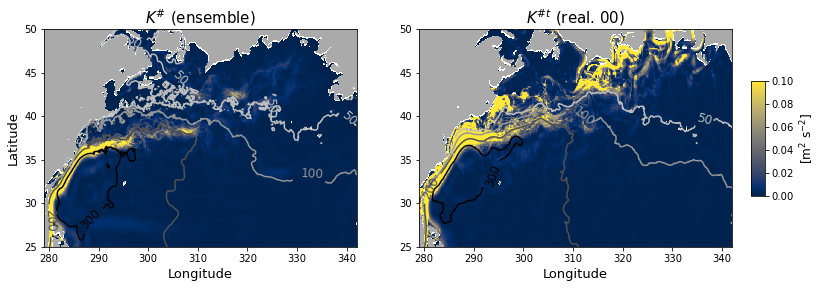

In [85]:
fig, axes = plt.subplots(figsize=(13,4), nrows=1, ncols=2)
# fig.set_tight_layout(True)

im2 = axes[0].pcolormesh(ds.XC, ds.YC, 
                         ensKE.isel(time=0,delta_outer=19), 
                         vmin=0, vmax=.1, shading='auto', cmap='cividis', rasterized=True)
im3 = axes[1].pcolormesh(ds.XC, ds.YC, 
                         annKE.isel(time=0,delta_outer=18),
                         vmin=0, vmax=.1, shading='auto', cmap='cividis', rasterized=True)

cs0 = axes[0].contour(ds.XC, ds.YC, 
                      -dsensZ.zetab.isel(time=0,delta_outer=19), 
                      levels=[-100,-10,50,100,200,300], cmap='Greys')
cs1 = axes[1].contour(ds.XC, ds.YC, 
                      -dsannZ.zetab.where(dsannZ.dzetab!=0.).isel(time=0,delta_outer=18),
                      levels=[-100,-10,50,100,200,300], cmap='Greys')

axes[0].pcolormesh(ds.XC, ds.YC, 
                   np.ma.masked_array(ensmask[...,19], ~ensmask[...,19]), 
                   vmin=0, vmax=3, cmap='binary', shading='auto', rasterized=True)
axes[1].pcolormesh(ds.XC, ds.YC, 
                   np.ma.masked_array(annmask[...,18], ~annmask[...,18]),
                   vmin=0, vmax=3, cmap='binary', shading='auto', rasterized=True)

axes[0].clabel(cs0, inline=True, fontsize=12, fmt='%.f')
axes[1].clabel(cs1, inline=True, fontsize=12, fmt='%.f')
for c in cs0.collections:
    c.set_rasterized(True)
for c in cs1.collections:
    c.set_rasterized(True)

axes[0].set_ylim([25,50])
axes[1].set_ylim([25,50])
axes[0].set_xlim([279,342])
axes[1].set_xlim([279,342])

axes[0].set_title(r"$K^\#$ (ensemble)", fontsize=15)
axes[1].set_title(r"$K^{\# t}$ (real. 00)", 
                    fontsize=15)

axes[0].set_xlabel(r"Longitude", fontsize=13)
axes[1].set_xlabel(r"Longitude", fontsize=13)
axes[0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86)
cbaxes2 = fig.add_axes([0.88, 0.3, 0.015, 0.4]) 
cbar2 = fig.colorbar(im2, cax=cbaxes2)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
# cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
# cbar3.set_label(r"[s$^{-1}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/mean_5Dave-delta_isig%02d_Jan-03_comp.pdf' % 19))

In [43]:
nsig = 23
HensMKE = ((ensMKE.where(dsensZ.dzetab!=0.)
            * ds.rA*dsensZ.dzetab).isel(YC=slice(1,-1),XC=slice(279,342),
                                         delta_outer=slice(19,nsig+1)).sum(['YC','XC','delta_outer'],skipna=True)
           / (ds.rA*dsensZ.dzetab).where(dsensZ.dzetab!=0.).isel(YC=slice(1,-1),XC=slice(279,342),
                                                                 delta_outer=slice(None,nsig+1)
                                                                ).sum(['YC','XC','delta_outer'],skipna=True)
          )
HensEKE = ((ensEKE.where(dsensZ.dzetab!=0.)
            * ds.rA*dsensZ.dzetab).isel(YC=slice(1,-1),XC=slice(279,342),
                                         delta_outer=slice(19,nsig+1)).sum(['YC','XC','delta_outer'],skipna=True)
           / (ds.rA*dsensZ.dzetab).where(dsensZ.dzetab!=0.).isel(YC=slice(1,-1),XC=slice(279,342),
                                                                 delta_outer=slice(None,nsig+1)
                                                                ).sum(['YC','XC','delta_outer'],skipna=True)
          )
HannMKE = ((annMKE.where(dsannZ.dzetab!=0.)
            * ds.rA*dsannZ.dzetab).isel(YC=slice(1,-1),XC=slice(279,342),
                                        delta_outer=slice(18,nsig+1)).sum(['YC','XC','delta_outer'],skipna=True)
           / (ds.rA*dsannZ.dzetab).where(dsannZ.dzetab!=0.).isel(YC=slice(1,-1),XC=slice(279,342),
                                                                 delta_outer=slice(None,nsig+1)
                                                                ).sum(['YC','XC','delta_outer'],skipna=True)
          )
HensEKE

<xarray.DataArray (time: 73)>
dask.array<truediv, shape=(73,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Dimensions without coordinates: time

In [44]:
AannMKE = ((annMKE.where(dsannZ.dzetab!=0.)
            * ds.rA).isel(YC=slice(1,-1),XC=slice(279,342)).sum(['YC','XC'],skipna=True)
           / (ds.rA).where(dsannZ.dzetab!=0.).isel(YC=slice(1,-1),XC=slice(279,342)).sum(['YC','XC'],skipna=True)
          )
AensMKE = ((ensMKE.where(dsannZ.dzetab!=0.)
            * ds.rA).isel(YC=slice(1,-1),XC=slice(279,342)).sum(['YC','XC'],skipna=True)
           / (ds.rA).where(dsensZ.dzetab!=0.).isel(YC=slice(1,-1),XC=slice(279,342)).sum(['YC','XC'],skipna=True)
          )
AannMKE

/tank/tdgs/tuchida/envs/sep2021/lib/python3.9/site-packages/dask/array/core.py:4369: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(


<xarray.DataArray (time: 73, delta_outer: 55)>
dask.array<truediv, shape=(73, 55), dtype=float32, chunksize=(73, 5), chunktype=numpy.ndarray>
Coordinates:
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: time

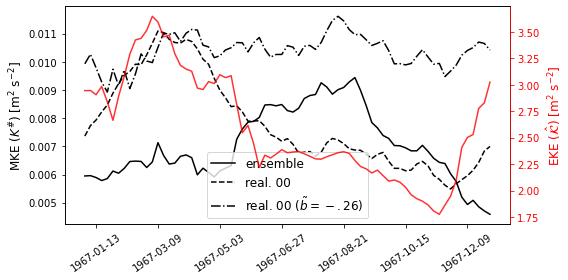

In [49]:
time = np.arange('1967-01-03','1967-12-31',np.timedelta64(5,'D'),
                 dtype='datetime64')

fig, ax = plt.subplots(figsize=(8,4))
fig.set_tight_layout(True)

ax2 = ax.twinx()

ax.plot(time, HensMKE, c='k', alpha=1., label=r"ensemble")
ax.plot(time, HannMKE, c='k', ls='--', alpha=1., label=r"real. 00")
ax2.plot(time, HensEKE, c='r', alpha=.8, label=r"")
ax.plot(time, AannMKE.isel(delta_outer=nsig), c='k', ls='-.', alpha=1., label=r"real. 00 ($\tilde{b}=-.26$)")
    
ax.set_xticks(time[2::11])
ax.set_xticklabels(time[2::11], rotation=35)
# ax.set_xlim(['1967-01-01','1967-12-31'])
# ax.set_ylim([0.0065,0.016])
# ax.set_ylim([.004,.0125])
ax.set_ylabel(r"MKE ($K^\#$) [m$^2$ s$^{-2}$]", fontsize=12)
ax.legend(loc='lower center', fontsize=12)

ax2.set_ylabel(r"EKE ($\hat{\mathcal{K}}$) [m$^2$ s$^{-2}$]", fontsize=12, c='r')
ax2.spines['right'].set_color('red')
# ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')

plt.savefig(op.join(savedir,'Figures/AKE_5Dave_nsig%02d_1967.pdf' % nsig))